WHO-COVID-19-global-daily-data

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## NUMERICAL SOLUTION

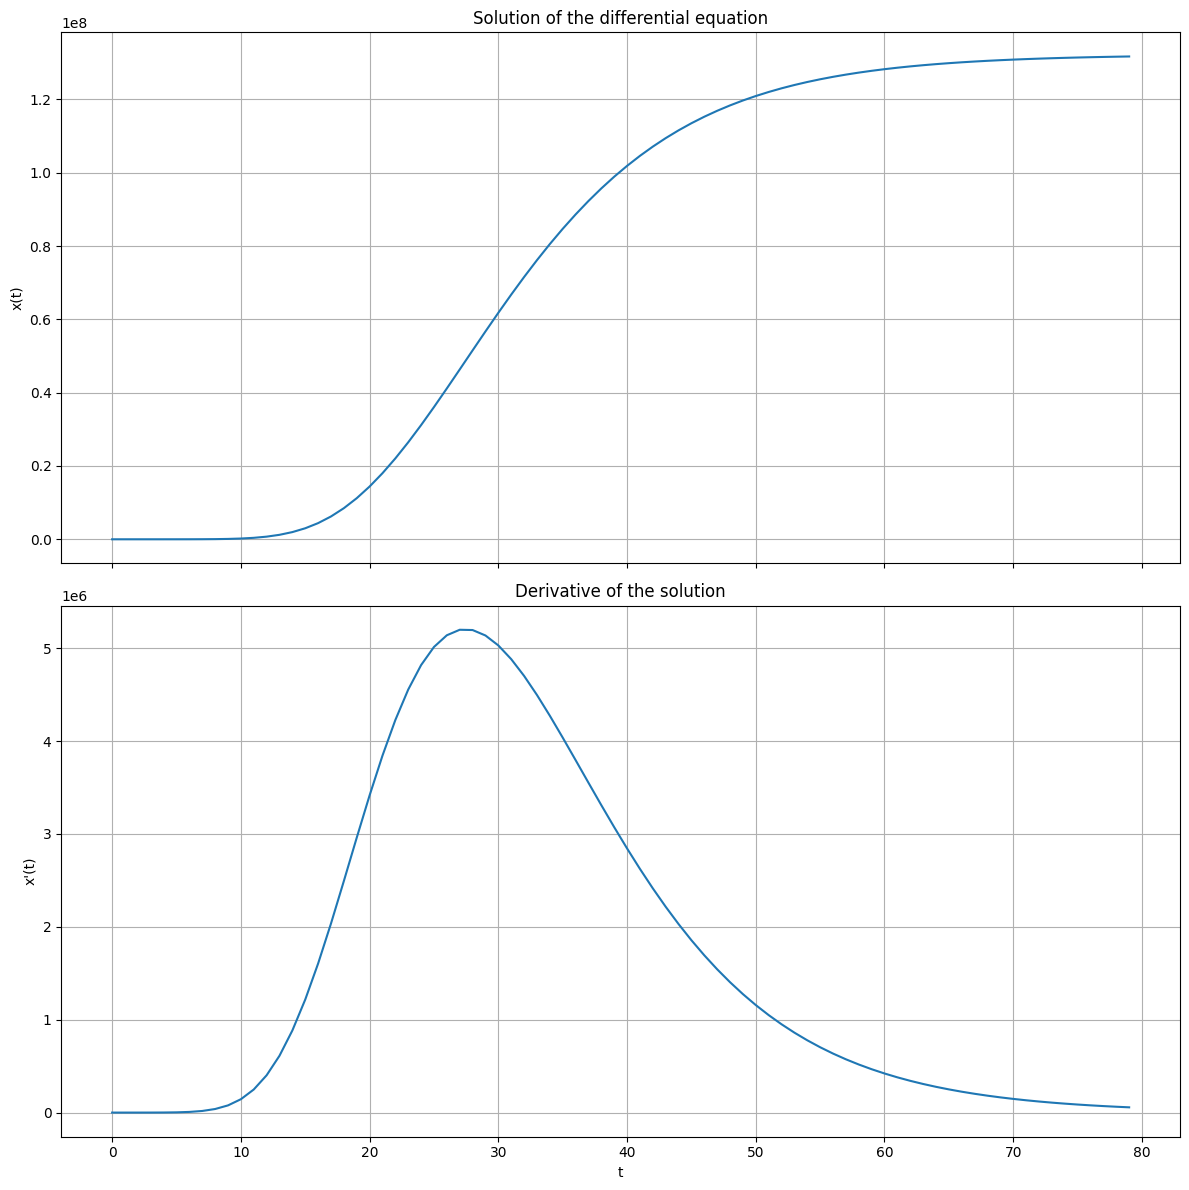

In [58]:
# parameters
alpha_1 = 4.7038 #1+(1-beta_1)/epsilon
alpha_2 = -2.7031 # -beta_0/epsilon
epsilon = 0.03958 #epsilon
x0 = 1.0
sigma =500

# gradient
def model(x, t):
    dxdt = alpha_1 * x + alpha_2 * x *(1 + epsilon*np.log(x)+ (epsilon*np.log(x))**2/2)
    return dxdt

# number of points
n=8000
dt=0.01

# time points
t_grid = np.linspace(0, n*dt, n)

# preallocate array for solution
x = np.zeros(n)

x[0]=x0

for i in range(1,n):
    t = t_grid[i]
    dx = dt*model(x[i-1], t) 
    x[i] = x[i-1]+dx

# compute derivative of solution
#dxdt = alpha_1 * x + alpha_2 * x ** (1 + epsilon)
dxdt = model(x, t_grid)

val = max(int(1/dt),1)
x=x[::val]
t_grid=t_grid[::val]
dxdt = dxdt[::val] #+ np.random.normal(0,sigma, len(x))


# create two subplots that share the same x-axis
fig, axs = plt.subplots(2, 1, figsize=(12, 12), sharex=True)

# plot the solution on the first subplot
axs[0].plot(t_grid, x)
axs[0].set_ylabel('x(t)')
axs[0].set_title('Solution of the differential equation')
axs[0].grid()

# plot the derivative on the second subplot
axs[1].plot(t_grid, dxdt)
axs[1].set_xlabel('t')
axs[1].set_ylabel("x'(t)")
axs[1].set_title("Derivative of the solution")
axs[1].grid()

# layout so plots do not overlap
fig.tight_layout()

plt.show()

## REAL DATA

In [3]:
df= pd.read_csv('./data/WHO-COVID-19-global-daily-data.csv')

In [4]:
start_date = '2020-02-15'
end_date = '2020-07-15'

italy_df = df[(df['Country'] == 'Italy') & 
              (df['Date_reported'] >= start_date) & 
              (df['Date_reported'] <= end_date)]

In [23]:
italy_df.describe()

,Date_reported,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Temperatura_Media_x,Temperatura_Media_y,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
count,137,130.000000,137.000000,130.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000
mean,2020-04-23 00:00:00,1852.553846,145518.540146,267.261538,19916.474453,15.943606,15.943606,-47.536927,-26.894085,-19.874338,-47.551343,-37.203402,15.698804
min,2020-02-15 00:00:00,14.000000,3.000000,0.000000,0.000000,4.240490,4.240490,-95.913386,-94.682540,-89.790323,-90.040650,-88.677165,-5.174603
25%,2020-03-20 00:00:00,328.750000,41035.000000,53.000000,3405.000000,11.447669,11.447669,-79.385827,-43.629921,-72.944882,-75.476190,-59.118110,5.088000
50%,2020-04-23 00:00:00,984.500000,187327.000000,170.000000,25085.000000,16.800978,16.800978,-43.047244,-22.527559,-21.677165,-47.677165,-34.559055,14.188976
75%,2020-05-27 00:00:00,3213.000000,230555.000000,461.500000,32955.000000,19.543701,19.543701,-14.653543,-6.385827,15.905512,-24.944882,-20.929134,26.228346
max,2020-06-30 00:00:00,6557.000000,240835.000000,969.000000,34744.000000,26.990150,26.990150,3.267717,20.385827,142.950413,11.588710,7.677165,39.304000
std,NaN,1810.089998,93646.652249,256.668506,13753.170459,5.108814,5.108814,32.591824,25.051661,53.320059,27.772420,23.164817,11.337321


In [ ]:
# Assuming 'date' is in datetime format, you can plot the data as follows:
import matplotlib.dates as mdates


plt.figure(figsize=(12,6))
plt.plot(italy_df['Date_reported'], italy_df['New_cases'])  # Replace 'cases' with the actual column name
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('COVID-19 cases in Italy over time')
plt.grid()
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=30))

plt.show()

## ALGEBRAIC SOLUTION

In [ ]:
# Constants
alpha_1 = 4.4 #1+(1-beta_1)/epsilon
alpha_2 = -2.6 # -beta_0/epsilon
epsilon = 0.020 #epsilon

N0 = 1

V0 = N0**(-epsilon)
VSS = alpha_2/(1-alpha_1)

def V_func(t):
    return (V0-VSS)*np.exp(epsilon*(1-alpha_1)*t) + VSS

def V_prime_func(t):
    return epsilon*(1-alpha_1)*(V0-VSS)*np.exp(epsilon*(1-alpha_1)*t)

# Generate x values
x_values = np.linspace(0, 150, 100)  # Adjust range as needed
V_values = V_func(x_values)
V_prime_values = V_prime_func(x_values)

N_values = V_values**(-1/epsilon)
N_prime_values = -N_values*V_prime_values/(epsilon*V_values)


In [ ]:
# Plotting V
plt.figure(figsize=(10, 6))
plt.plot(x_values, V_values, label=r'$V$', color='red')
plt.plot(x_values, V_prime_values, label=r"$V'$")
plt.grid()
plt.legend()
plt.show()

In [ ]:
# Plotting N
plt.figure(figsize=(10, 6))
#plt.plot(x_values, N_values, label=r'$V$', color='red')
plt.plot(x_values, N_prime_values, label=r"$V'$")
plt.grid()
plt.legend()
plt.show()

## PLOT DATA + RESULTS

In [ ]:
# From Stata

model_list =['S2', 'S3', 'S4', 'Sln']
alpha_1_list = [4.28, 7.05, 7.46, 7.50]
alpha_2_list = [-2.53, -4.98, -5.47, -5.47]
epsilon_list = [0.021, 0.016, 0.014, 0.014]

model_df = pd.DataFrame({
    'instruments': model_list,
    'alpha_1': alpha_1_list,
    'alpha_2': alpha_2_list,
    'epsilon': epsilon_list
})


In [45]:
# From Grid Search

model_list =['T2', 'G3', 'F']
alpha_1_list = [2.526, 3.94, 4.7]
alpha_2_list = [-0.921, -2.9, -2.7135]
epsilon_list = [0.0407, 0.020, 0.03854]


model_df = pd.DataFrame({
    'instruments': model_list,
    'alpha_1': alpha_1_list,
    'alpha_2': alpha_2_list,
    'epsilon': epsilon_list
})

In [46]:
def N_prime_func(t_values, epsilon, alpha_1, alpha_2, N0=3):
    V0 = N0**(-epsilon)
    VSS = alpha_2/(1-alpha_1)
    
    def V_func(t):
        return (V0-VSS)*np.exp(epsilon*(1-alpha_1)*t) + VSS
    
    def V_prime_func(t):
        return epsilon*(1-alpha_1)*(V0-VSS)*np.exp(epsilon*(1-alpha_1)*t)
    
    # Generate x values
    V_values = V_func(t_values)
    V_prime_values = V_prime_func(t_values)
    
    N_values = V_values**(-1/epsilon)
    N_prime_values = -N_values*V_prime_values/(epsilon*V_values)
    
    return N_prime_values



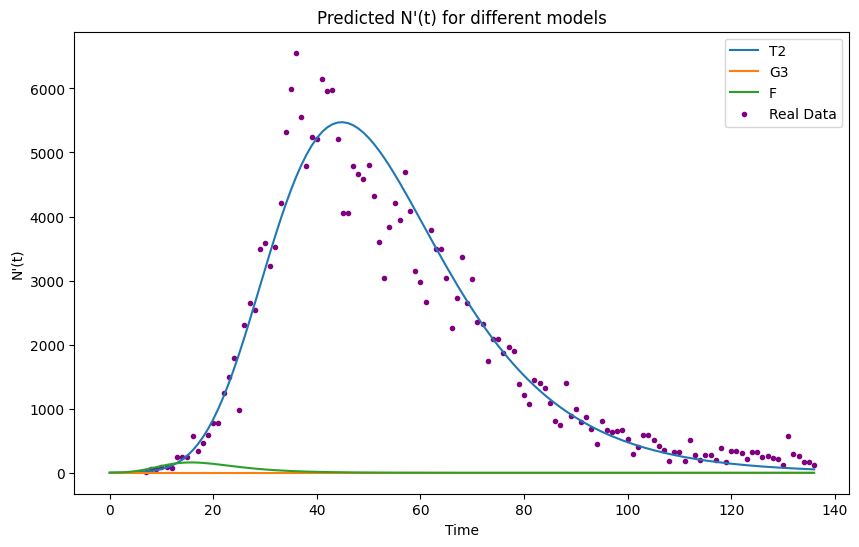

In [47]:
t_values = np.arange(len(italy_df['New_cases']))

# Compute N_prime_func for each model
plt.figure(figsize=(10, 6))
N0=3
for i, row in model_df.iterrows():
    N_prime_values = N_prime_func(t_values, row['epsilon'], row['alpha_1'], row['alpha_2'], N0=1)
    plt.plot(t_values, N_prime_values, label=row['instruments'])

# Load real data (replace with actual dataset)
# Assuming real data is a DataFrame with columns: 'time' and 'N_prime_real'

# Plot real data
plt.scatter(t_values, italy_df['New_cases'], label='Real Data', marker='.', color='purple')

plt.xlabel('Time')
plt.ylabel('N\'(t)')
plt.title('Predicted N\'(t) for different models')
plt.legend()
plt.show()

## Collinearity analysis

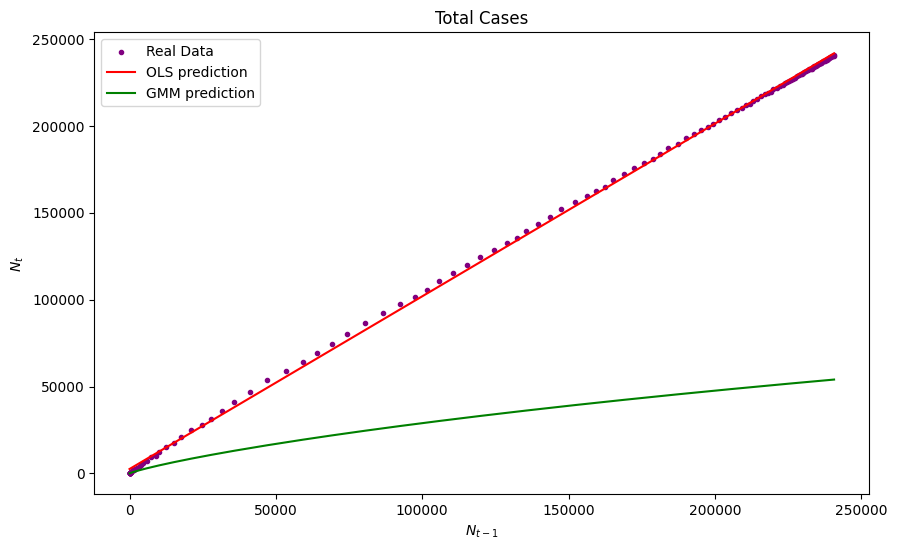

In [44]:
from Econometrics.Coronavirus.code.read_data import dta
import statsmodels.api as sm
import matplotlib.pyplot as plt

y = dta["Cumulative_cases"]
x = dta["Cumulative_cases_lag_1"]

# Add a constant to the independent value
x = sm.add_constant(x)

# Fit the model
model = sm.OLS(y, x).fit()

# Get the predicted values
y_pred = model.predict(x)

alpha_1 = 3.94 #1+(1-beta_1)/epsilon
alpha_2 = -2.9 # -beta_0/epsilon
epsilon = 0.020 #epsilon

N = x[x.columns[1]]+10**(-6)
y_pred_2 = alpha_1*x[x.columns[1]]+ alpha_2*x[x.columns[1]]**(1+epsilon)
#y_pred_2 = (alpha_1 + alpha_2)*N + alpha_2*epsilon*N*np.log(N) + alpha_2*N*(epsilon*np.log(N))**2 /2


plt.figure(figsize=(10, 6))

plt.scatter(x[x.columns[1]], y, marker='.', label='Real Data', color = 'purple')
plt.plot(x[x.columns[1]], y_pred, label='OLS prediction', color='red')
plt.plot(x[x.columns[1]], y_pred_2, label='GMM prediction', color ='green')

plt.ylabel(r'$N_t$')
plt.xlabel(r'$N_{t-1}$')
plt.title('Total Cases')
plt.legend()
plt.show()

In [ ]:
from Econometrics.Coronavirus.code.read_data import dta
import statsmodels.api as sm
import matplotlib.pyplot as plt

y = dta["Cumulative_cases"]
x = dta["Cumulative_cases_lag_1"]

# Add a constant to the independent value
x = sm.add_constant(x)

# Fit the model
model = sm.OLS(y, x).fit()

# Get the predicted values
y_pred = model.predict(x)

# Create a figure with three subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 12))

# Zoom in on the first part of the plot
axs[0].scatter(x[x.columns[1]], y, marker='.', color='purple')
axs[0].plot(x[x.columns[1]], y_pred, color='red')
axs[0].plot(x[x.columns[1]], y_pred_2, label='GMM prediction', color ='green')
axs[0].set_xlim(0, 5000)  # Set the x-axis limits to zoom in
axs[0].set_ylim(0, 5000)  # Set the y-axis limits to zoom in
axs[0].set_title('Zoomed In [0,5k]')

# Zoom in on the second part of the plot
axs[1].scatter(x[x.columns[1]], y, marker='.', color='purple')
axs[1].plot(x[x.columns[1]], y_pred, color='red')
axs[1].plot(x[x.columns[1]], y_pred_2, label='GMM prediction', color ='green')
axs[1].set_xlim(100000, 120000)  # Set the x-axis limits to zoom in
axs[1].set_ylim(100000, 120000)  # Set the y-axis limits to zoom in
axs[1].set_title('Zoomed In [100k,120k]')

# Zoom in on the third part of the plot
axs[2].scatter(x[x.columns[1]], y, marker='.', color='purple')
axs[2].plot(x[x.columns[1]], y_pred, color='red')
axs[2].plot(x[x.columns[1]], y_pred_2, label='GMM prediction', color ='green')
axs[2].set_xlim(220000, 230000)  # Set the x-axis limits to zoom in
axs[2].set_ylim(220000, 230000)  # Set the y-axis limits to zoom in
axs[2].set_title('Zoomed In [220k, 230k]')


plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import chi2

# Define the degrees of freedom
df = 2

# Calculate the chi-squared quantile for a given probability
probability = 0.95
quantile = chi2.ppf(probability, df)

print(f"The chi-squared quantile for probability {probability} and df {df} is {quantile}")

## Temperature Data

In [ ]:
import xarray as xr

# Define the file path (use a raw string to avoid issues with backslashes)
path = r"C:\Users\leocr\Projects\Economics\Econometrics\Coronavirus\data\data.grib"

# Open the GRIB file using xarray with the 'cfgrib' engine
ds = xr.open_dataset(path, engine="cfgrib")

# Print a summary of the dataset
print(ds)


In [ ]:
# Supponiamo che la variabile si chiami 't2m'
# Convertiamo da Kelvin a Celsius sottraendo 273.15
ds['t2m_celsius'] = ds['t2m'] - 273.15

# Calcola la media spaziale (su latitudine e longitudine)
# I nomi delle dimensioni potrebbero essere 'latitude' e 'longitude' o simili.
# Verifica con print(ds) se necessario.
ds_mean = ds['t2m_celsius'].mean(dim=['latitude', 'longitude'])

# Converti i dati in un DataFrame con indice data e colonna "Temperatura_Media"
df_temperature = ds_mean.to_dataframe(name="Temperatura_Media").reset_index()

df_temperature=df_temperature[["time","Temperatura_Media"]]

# Visualizza le prime righe del dataset
df_temperature.head()

In [5]:
# Salva il dataset in un file CSV (opzionale)
df_temperature.to_csv("temperature_medi_italia_2020_1-6.csv", index=False)

NameError: name 'df_temperature' is not defined

In [18]:
df_temp = pd.read_csv('./data/italy_data_temperature.csv')

df_temp.loc[:, 'time'] = pd.to_datetime(df_temp['time'])
italy_df.loc[:, 'Date_reported'] = pd.to_datetime(italy_df['Date_reported'])

# Merge the two DataFrames on the common date
italy_df = italy_df.merge(df_temp, left_on='Date_reported', right_on='time', how='inner')

# Drop duplicate date columns (keeping one of them)
italy_df = italy_df.drop(columns=['time'])

# Show the first few rows
italy_df

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Temperatura_Media_x,Temperatura_Media_y
0,2020-02-15 00:00:00,IT,Italy,EUR,NaN,3,NaN,0,10.779569,10.779569
1,2020-02-16 00:00:00,IT,Italy,EUR,NaN,3,NaN,0,11.208646,11.208646
2,2020-02-17 00:00:00,IT,Italy,EUR,NaN,3,NaN,0,11.447669,11.447669
3,2020-02-18 00:00:00,IT,Italy,EUR,NaN,3,NaN,0,10.152233,10.152233
4,2020-02-19 00:00:00,IT,Italy,EUR,NaN,3,NaN,0,9.248680,9.248680
...,...,...,...,...,...,...,...,...,...,...
132,2020-06-26 00:00:00,IT,Italy,EUR,296.0,240105,14.0,34698,25.617771,25.617771
133,2020-06-27 00:00:00,IT,Italy,EUR,255.0,240360,10.0,34708,26.552326,26.552326
134,2020-06-28 00:00:00,IT,Italy,EUR,175.0,240535,8.0,34716,26.990150,26.990150
135,2020-06-29 00:00:00,IT,Italy,EUR,174.0,240709,22.0,34738,26.284124,26.284124


In [7]:
df_mob = pd.read_csv('./data/italy_data_mobility.csv')

df_mob

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,place_id,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,IT,Italy,NaN,NaN,NaN,NaN,NaN,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-15,3.0,-1.0,35.0,9.0,0.0,-1.0
1,IT,Italy,NaN,NaN,NaN,NaN,NaN,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-16,3.0,2.0,26.0,11.0,1.0,-2.0
2,IT,Italy,NaN,NaN,NaN,NaN,NaN,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-17,0.0,1.0,7.0,3.0,1.0,0.0
3,IT,Italy,NaN,NaN,NaN,NaN,NaN,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-18,3.0,1.0,16.0,4.0,1.0,0.0
4,IT,Italy,NaN,NaN,NaN,NaN,NaN,ChIJA9KNRIL-1BIRb15jJFz1LOI,2020-02-19,0.0,-1.0,11.0,3.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40759,IT,Italy,Veneto,Province of Vicenza,NaN,IT-VI,NaN,ChIJ6bkyp9bKeEcR4H6QFYcJBwM,2020-12-27,-77.0,-32.0,-52.0,-64.0,-28.0,16.0
40760,IT,Italy,Veneto,Province of Vicenza,NaN,IT-VI,NaN,ChIJ6bkyp9bKeEcR4H6QFYcJBwM,2020-12-28,-57.0,-22.0,-25.0,-61.0,-57.0,25.0
40761,IT,Italy,Veneto,Province of Vicenza,NaN,IT-VI,NaN,ChIJ6bkyp9bKeEcR4H6QFYcJBwM,2020-12-29,-37.0,18.0,-16.0,-59.0,-51.0,21.0
40762,IT,Italy,Veneto,Province of Vicenza,NaN,IT-VI,NaN,ChIJ6bkyp9bKeEcR4H6QFYcJBwM,2020-12-30,-32.0,45.0,-3.0,-56.0,-50.0,19.0


In [10]:
df_mob = df_mob[['date', 'retail_and_recreation_percent_change_from_baseline', 'grocery_and_pharmacy_percent_change_from_baseline', 'parks_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline', 'residential_percent_change_from_baseline']]

df_mob.loc[:, 'date'] = pd.to_datetime(df_mob['date'])

# Group by 'date' and calculate the mean for each group
df_mob = df_mob.groupby('date').mean().reset_index()


df_mob

,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,2.141732,-1.551181,31.220472,7.204724,0.102362,-1.031496
1,2020-02-16,3.267717,-0.992126,32.299213,11.588710,0.527559,-1.341270
2,2020-02-17,-0.622047,0.314961,5.645669,2.952000,0.944882,-0.275591
3,2020-02-18,1.622047,-0.566929,17.519685,2.968254,1.039370,-0.196850
4,2020-02-19,-0.173228,-0.818898,7.330709,1.619048,0.850394,-0.204724
...,...,...,...,...,...,...,...
316,2020-12-27,-71.448819,-28.165354,-54.960630,-59.177419,-28.488189,15.307087
317,2020-12-28,-33.598425,-0.409449,-25.094488,-48.666667,-44.921260,17.968504
318,2020-12-29,-26.921260,14.566929,-7.464567,-43.309524,-42.385827,16.070866
319,2020-12-30,-21.976378,39.267717,-9.055118,-40.134921,-41.716535,14.992126


In [17]:
italy_df.loc[:, 'Date_reported'] = pd.to_datetime(italy_df['Date_reported'])

# Show the first few rows
italy_df


,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Temperatura_Media
0,2020-02-15 00:00:00,IT,Italy,EUR,NaN,3,NaN,0,10.779569
1,2020-02-16 00:00:00,IT,Italy,EUR,NaN,3,NaN,0,11.208646
2,2020-02-17 00:00:00,IT,Italy,EUR,NaN,3,NaN,0,11.447669
3,2020-02-18 00:00:00,IT,Italy,EUR,NaN,3,NaN,0,10.152233
4,2020-02-19 00:00:00,IT,Italy,EUR,NaN,3,NaN,0,9.248680
...,...,...,...,...,...,...,...,...,...
132,2020-06-26 00:00:00,IT,Italy,EUR,296.0,240105,14.0,34698,25.617771
133,2020-06-27 00:00:00,IT,Italy,EUR,255.0,240360,10.0,34708,26.552326
134,2020-06-28 00:00:00,IT,Italy,EUR,175.0,240535,8.0,34716,26.990150
135,2020-06-29 00:00:00,IT,Italy,EUR,174.0,240709,22.0,34738,26.284124


In [21]:
# Merge the two DataFrames on the common date
merged_df = italy_df.merge(df_mob, left_on='Date_reported', right_on='date', how='inner')

# Drop duplicate date columns (keeping one of them)
italy_df = merged_df.drop(columns=['date'])

In [20]:
italy_df['Date_reported'] = pd.to_datetime(italy_df['Date_reported'])


print(df_mob['date'].dtype)  # Should be datetime64[ns]
print(italy_df['Date_reported'].dtype)  # Should be datetime64[ns]



datetime64[ns]
datetime64[ns]


In [22]:
italy_df

,Date_reported,Country_code,Country,WHO_region,New_cases,Cumulative_cases,New_deaths,Cumulative_deaths,Temperatura_Media_x,Temperatura_Media_y,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,2020-02-15,IT,Italy,EUR,NaN,3,NaN,0,10.779569,10.779569,2.141732,-1.551181,31.220472,7.204724,0.102362,-1.031496
1,2020-02-16,IT,Italy,EUR,NaN,3,NaN,0,11.208646,11.208646,3.267717,-0.992126,32.299213,11.588710,0.527559,-1.341270
2,2020-02-17,IT,Italy,EUR,NaN,3,NaN,0,11.447669,11.447669,-0.622047,0.314961,5.645669,2.952000,0.944882,-0.275591
3,2020-02-18,IT,Italy,EUR,NaN,3,NaN,0,10.152233,10.152233,1.622047,-0.566929,17.519685,2.968254,1.039370,-0.196850
4,2020-02-19,IT,Italy,EUR,NaN,3,NaN,0,9.248680,9.248680,-0.173228,-0.818898,7.330709,1.619048,0.850394,-0.204724
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132,2020-06-26,IT,Italy,EUR,296.0,240105,14.0,34698,25.617771,25.617771,-8.976378,-3.110236,82.086614,-18.496000,-25.385827,3.685039
133,2020-06-27,IT,Italy,EUR,255.0,240360,10.0,34708,26.552326,26.552326,-12.204724,-7.519685,97.960630,-3.696000,-14.456693,-1.496063
134,2020-06-28,IT,Italy,EUR,175.0,240535,8.0,34716,26.990150,26.990150,-13.763780,-16.551181,91.141732,-0.314516,7.677165,-5.174603
135,2020-06-29,IT,Italy,EUR,174.0,240709,22.0,34738,26.284124,26.284124,-4.118110,-2.291339,82.717742,-19.064000,-24.653543,3.244094
